In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F

import os
os.environ['CUDA_VISIBLE_DEVICES'] = '0'

In [2]:
# model configuration
model_path = './save/edsr-baseline-lte.pth'

# image configuration
lr_path = './demo/Urban100_img012x2.png'
gt_path = './demo/Urban100_img012.png'
scale = 2
xx = 360
yy = 660
obs_size = 120


In [3]:
import models

from torchvision import transforms
from PIL import Image

# load model
model_spec = torch.load(model_path)['model']
model = models.make(model_spec, load_sd=True).cuda()

# load image
img_lr = transforms.ToTensor()(Image.open(lr_path).convert('RGB'))
img_gt = transforms.ToTensor()(Image.open(gt_path).convert('RGB'))


In [4]:
# evaluation
inp = (img_lr.unsqueeze(0).cuda() - 0.5) / 0.5

model.eval()
with torch.no_grad():
    model.gen_feat(inp.flip(-2)) # due to a digital image coordinate conventions (https://blogs.mathworks.com/steve/2011/08/26/digital-image-processing-using-matlab-digital-image-representation/)   
    freq = model.freq(model.feat).flip(-2)
    coef = model.coef(model.feat).flip(-2)

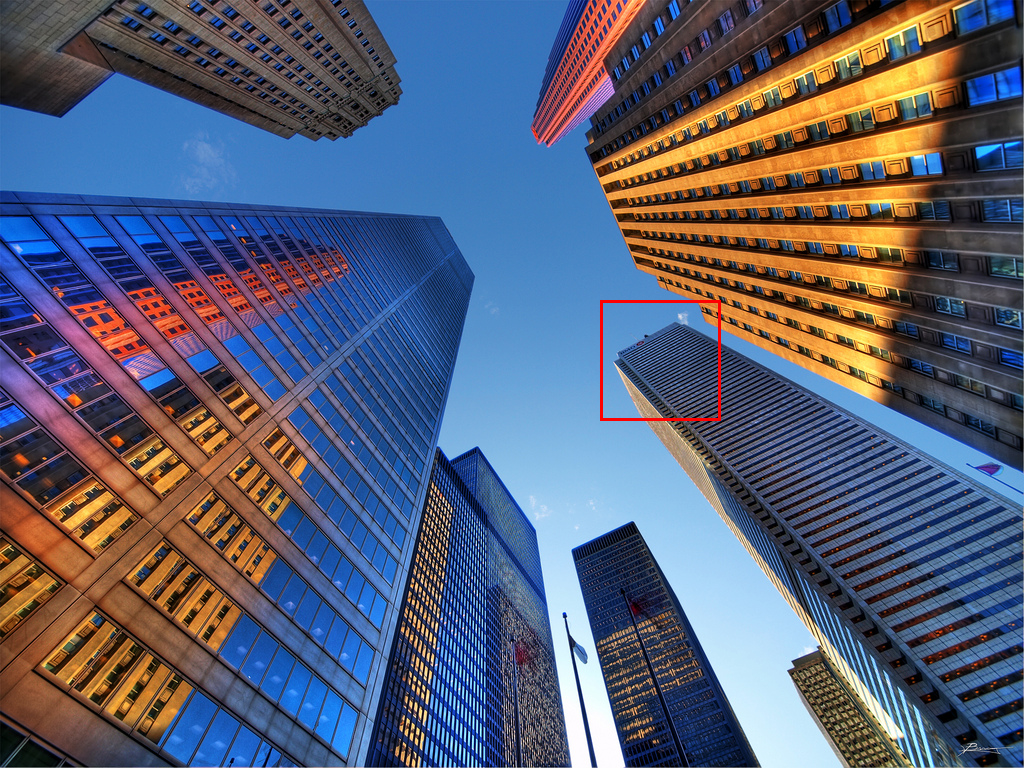

In [5]:
from PIL import ImageDraw

# Display GT
im = Image.open(gt_path).convert('RGB')
draw = ImageDraw.Draw(im)
draw.rectangle([yy-obs_size//2, xx-obs_size//2, yy+obs_size//2, xx+obs_size//2], outline="red", width=3)
display(im)


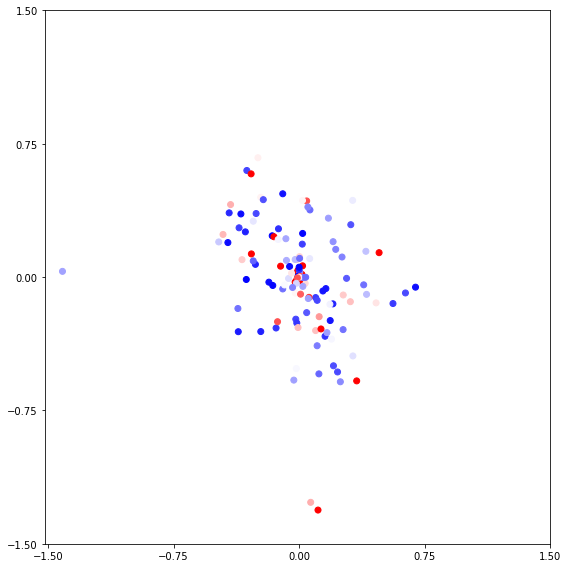

In [6]:
import matplotlib.pyplot as plt
import numpy as np

# Display Fourier Feature Space
plt.rcParams["figure.figsize"] = (8, 8)
freq_x = torch.stack(torch.split(freq, 2, dim=1), dim=2)[0, 1, :, xx//scale, yy//scale].cpu().numpy()
freq_y = torch.stack(torch.split(freq, 2, dim=1), dim=2)[0, 0, :, xx//scale, yy//scale].cpu().numpy()
mag    = (coef[0, :freq.shape[1]//2, xx//scale, yy//scale]**2 + coef[0, freq.shape[1]//2:, xx//scale, yy//scale]**2).cpu().numpy()
sc = plt.scatter(freq_x, freq_y, c=mag, vmin=0, vmax=max(mag)/4, s=None, cmap='bwr')
# plt.colorbar(sc)
plt.xticks(np.linspace(-1.5, 1.5, 5))
plt.yticks(np.linspace(-1.5, 1.5, 5))

plt.tight_layout()
plt.show()
